# Machine Learning Model MLP with Grid Search

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense


warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

In [44]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

### Prepare data

In [45]:
x_train = pd.read_csv('./data_f1/ANNData/cleaned_data.csv')
x_test = pd.read_csv('./data_f1/ANNData/cleaned_data_2022.csv')

In [46]:
x_train = x_train[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]
x_test = x_test[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [47]:
x_train = x_train[x_train['active_constructor']==1]
x_train = x_train[x_train['active_driver']==1]

x_test = x_test[x_test['active_constructor']==1]
x_test = x_test[x_test['active_driver']==1]

In [48]:
sc  = StandardScaler()
le = LabelEncoder()

x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
x_train['constructor'] = le.fit_transform(x_train['constructor'])
x_train['driver'] = le.fit_transform(x_train['driver'])
x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
X_train = x_train.drop(['position','active_driver','active_constructor'],axis=1)
y_train = x_train['position'].apply(lambda x: position_index(x))

x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
x_test['constructor'] = le.fit_transform(x_test['constructor'])
x_test['driver'] = le.fit_transform(x_test['driver'])
x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
X_test = x_test.drop(['position','active_driver','active_constructor'],axis=1)
y_test = x_test['position'].apply(lambda x: position_index(x))

### Hyperparameter tuning with GridSearch

In [49]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='relu', neurons=32):
    # create model
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(6,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons/2, activation=activation))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    # opt = optimizers.Adamax(learning_rate=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [50]:
model = KerasClassifier(model=create_model, verbose=0)

In [51]:
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
batch_size = [32, 64, 128]
epochs = [10, 25, 50]
optimizer = ['Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1]
momentum = [0.0, 0.2, 0.4]
activation = ['relu', 'tanh', 'sigmoid']
neurons = [16, 32, 64]

param_grid = dict(
                 batch_size=batch_size, 
                 epochs=epochs, 
                 optimizer__learning_rate=learn_rate, 
                 optimizer__momentum=momentum, 
                 model__optimizer=optimizer, 
                 model__activation=activation,
                 model__neurons=neurons
                 )

In [52]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid_search.fit(X_train, y_train)

In [54]:
# Print the best hyperparameters and the best score
print("Best hyperparameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)

Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'model__activation': 'sigmoid', 'model__neurons': 64, 'model__optimizer': 'Adamax', 'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.2}
Best score: 0.9496331548681339


In [55]:
# Re-train the model with the best hyperparameters
best_clf = grid_result.best_estimator_
best_clf.fit(X_train, y_train)

KerasClassifier(
	model=<function create_model at 0x7f4dd0205630>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	model__activation=sigmoid
	model__neurons=64
	model__optimizer=Adamax
	optimizer__learning_rate=0.1
	optimizer__momentum=0.2
	class_weight=None
)

In [56]:
y_pred = best_clf.predict(X_test)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 56


In [57]:
 # Test the model with the best hyperparameters on the testing data
accuracy = best_clf.score(X_test, y_test)
print("Testing accuracy:", accuracy)

Testing accuracy: 0.8727272727272727


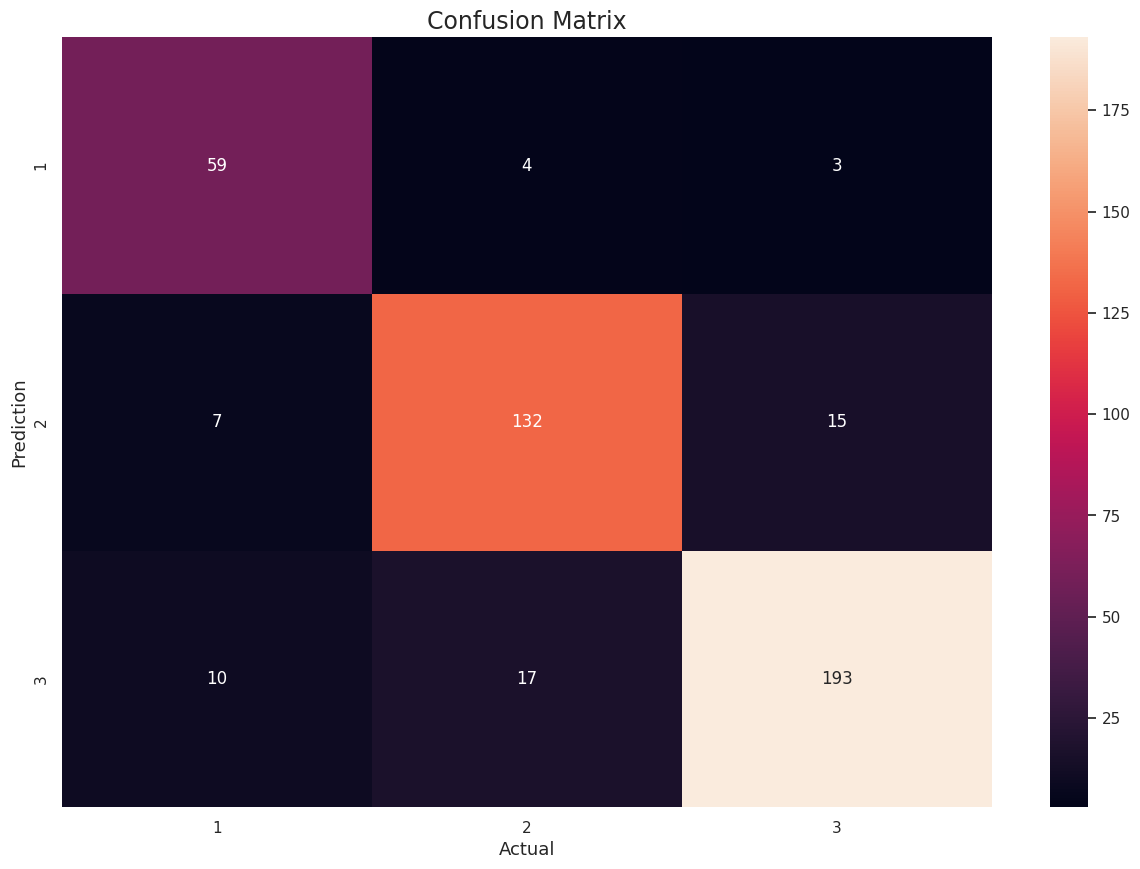

In [58]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()